# Clova.ai CRAFT for AWS Inferentia

This notebook demonstrates how to compile the Clova.ai CRAFT text detection model for AWS Inferentia.
Code adapted from the _test.py_ inference script provided in the official Clova.ai CRAFT repo

**Reference:** https://github.com/clovaai/CRAFT-pytorch

## 1) Install dependencies

In [ ]:
# Set extra Pip repository  to point to Torch stable
%pip config set global.extra-index-url https://download.pytorch.org/whl/torch_stable.html
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U googledrivedownloader opencv-python==4.6.0.66 scikit-image==0.17.2
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

### 1.1) Clone the CRAFT repo

In [ ]:
import os
if not os.path.isdir('craft'):
    !git clone https://github.com/clovaai/CRAFT-pytorch.git craft && \
    cd craft && git checkout e332dd8b718e291f51b66ff8f9ef2c98ee4474c8

### 1.2) Download a pretrained CRAFT model
Also see [CRAFT pretrained models](https://github.com/clovaai/CRAFT-pytorch#test-instruction-using-pretrained-model)

In [ ]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
model_file = './craft_mlt_25k.pth'
if not os.path.isfile(model_file):
    gdd.download_file_from_google_drive(file_id='1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ', dest_path=model_file)

## 2) Initialize libraries and prepare input samples

In [ ]:
import os
import sys
import torch
if not 'craft' in sys.path: sys.path.append('craft')

img_size=800
x = torch.rand(1,3,img_size,img_size)

## 3) Load a pre-trained model and check if it is .jit traceable

In [ ]:
from craft import CRAFT
from collections import OrderedDict

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

model = CRAFT()
model.load_state_dict(copyStateDict(torch.load(model_file, map_location='cpu')))
model.eval()

y = model(x) # warmup

try:
    traced = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:    
    print("Ops. Something went wrong. Model is not traceable")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model, example_inputs=x)

In [ ]:
import torch
import torch.neuron
model_neuron = torch.neuron.trace(model, example_inputs=x)

## Export to saved model
model_neuron.save("craft_neuron.pt")

### 4.1) Verify the optimized model

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## 5) A simple test to check the predictions

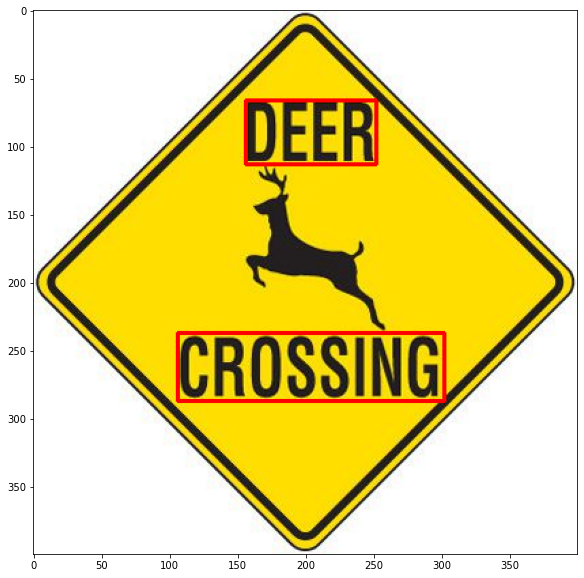

In [2]:
%matplotlib inline
import os
import sys
import cv2
import numpy as np
import urllib
import torch
import torch.neuron
import matplotlib.pyplot as plt

if not 'craft' in sys.path: sys.path.append('craft')
if not '..' in sys.path: sys.path.append('..')

from common import processing

# from craft
import imgproc # custom image processing library included in repo
import craft_utils

text_threshold,link_threshold,low_text,poly,img_size = 0.7,0.4,0.4,False,800

# load the model
model_neuron = torch.load('craft_neuron.pt')

# it needs to be a square image. if not make it squared first
img = processing.load_sample_imgD()
# pre-process the image
x,target_ratio = imgproc.resize_aspect_ratio(img, img_size, interpolation=cv2.INTER_LINEAR, mag_ratio=2)[0:2] # resize image to match model's expect input size
x = torch.from_numpy(imgproc.normalizeMeanVariance(x)).permute(2, 0, 1).unsqueeze(0) # [h, w, c] to [b, c, h, w]

# run the model
y, feature = model_neuron(x)

# make score and link map
score_text,score_link = y[0,:,:,0].numpy(),y[0,:,:,1].numpy()

boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)
ratio_h = ratio_w = 1 / target_ratio

# Coordinate adjustment
boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
for k in range(len(polys)):
    if polys[k] is None: polys[k] = boxes[k]

# plot the image with the bboxes around texts
img_out = img.copy()
for i, box in enumerate(boxes):
    poly = np.array(box).astype(np.int32).reshape((-1, 1, 2))
    cv2.polylines(img_out, [poly], True, color=(0, 0, 255), thickness=2)    
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))